In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results_model/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
    }
)
spme = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
    }
)
spme_li = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()
param=spme.param

In [3]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spme,parameter_values)
print(Temp)

25


In [4]:
parameter_values.update(
    {
      "Positive electrode LAM constant proportional term [s-1]": 1.27152e-07,
      "Negative electrode LAM constant proportional term [s-1]": 1.27272e-06,
      "Positive electrode LAM constant exponential term": 1.1992,
      "Negative electrode LAM constant exponential term": 1.1992,
      "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
      "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
      "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
      # "Exchange-current density for plating [A.m-2]":0.001,
      # "Lithium plating transfer coefficient": 0.7,
      # "Dead lithium decay constant [s-1]": 1E-4,
    },
    check_already_exists=False,
)

In [5]:
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    # ] *40,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [6]:
all_sumvars_dict_spm = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

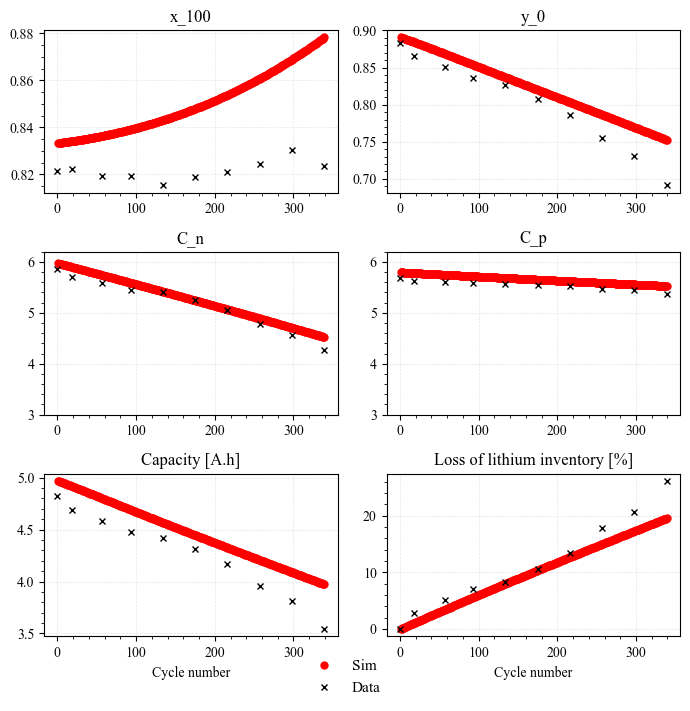

In [7]:
plotc(all_sumvars_dict_spm,dfe);

In [8]:
all_sumvars_dict_spme = cycle_adaptive_simulation(spme, parameter_values, experiment,SOC_0, save_at_cycles=1)

RuntimeError: .../casadi/core/function_internal.hpp:1257: Input 1 (i1) has mismatching shape. Got 243-by-1. Allowed dimensions, in general, are:
 - The input dimension N-by-M (here 123-by-1)
 - A scalar, i.e. 1-by-1
 - M-by-N if N=1 or M=1 (i.e. a transposed vector)
 - N-by-M1 if K*M1=M for some K (argument repeated horizontally)
 - N-by-P*M, indicating evaluation with multiple arguments (P must be a multiple of 1 for consistency with previous inputs)

In [ ]:
plotc(all_sumvars_dict_spme,dfe);

In [ ]:
def plotc2(all_sumvars_dict1,all_sumvars_dict2,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"bv")
        ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"r.")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["sim1", "sim2" , "Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
plotc2(all_sumvars_dict_spm,all_sumvars_dict_spme,dfe);